In [29]:
import pickle
import seaborn as sns
import numpy as np
import pandas as pd
import psycopg2
import nltk
import gensim
from gensim import corpora, models
import string
from nltk.stem import WordNetLemmatizer 
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database, drop_database
import matplotlib.pyplot as plt

In [30]:
sns.set_style('whitegrid')

In [31]:
with open('pg_credentials.p', 'rb') as f:
    pg_credentials = pickle.load(f)

In [32]:
host     = 'localhost'
db_name  = 'goodreads_db'
username = pg_credentials['username']
password = pg_credentials['password']
port = '5432'  # default port that postgres listens on
    
con = psycopg2.connect(database = db_name, user = username, host=host, password=password)

In [33]:
query = "SELECT reviews, true_score AS winner_frac FROM works_withgenre"
review_data = pd.read_sql_query(query, con)

In [6]:
import itertools
lemmatizer = WordNetLemmatizer() 

stopwords = (nltk.corpus.stopwords.words('english')
             + ['book', 'read'])

# First, get rid of proper nouns, as this is contaminating our topic modeling!
def remove_proper_nouns(review):
    tokens = review.split()
    review = ' '.join([t for t in tokens if t[:4].lower()!="http"])
    sentences = review.split('.')
    sentences = [s.split() for s in sentences]
    sentences = [' '.join([w for i, w in enumerate(words) if i==0 or w[0]==w[0].lower()]) for words in sentences]
    sentences = [s.lower() for s in sentences]
    return sentences

reviews = []
for review in review_data['reviews']:
    reviews.extend(remove_proper_nouns(review))
reviews_lemmatized = [[lemmatizer.lemmatize(t) 
                       for t in nltk.word_tokenize(review)] 
                      for review in reviews if review]
clean_reviews = [[r for r in review if r not in stopwords and len(r)>3] for review in reviews_lemmatized]

In [7]:
if False:
    dictionary = gensim.corpora.Dictionary(clean_reviews)
    dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=100000)
    bow_corpus = [dictionary.doc2bow(doc) for doc in clean_reviews]
    dictionary.save('dictionary.gensim')
else:
    dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')

In [9]:
if False:
    lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)
    lda_model.save('good_lda_model.gensim')
else:
    lda_model = gensim.models.LdaMulticore.load('good_lda_model.gensim')

In [10]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.069*"character" + 0.043*"really" + 0.022*"much" + 0.022*"story" + 0.020*"like" + 0.019*"well" + 0.016*"plot" + 0.011*"interesting" + 0.011*"feel" + 0.010*"main"
Topic: 1 
Words: 0.033*"know" + 0.030*"thing" + 0.027*"make" + 0.027*"would" + 0.019*"think" + 0.018*"want" + 0.016*"going" + 0.014*"even" + 0.012*"people" + 0.012*"said"
Topic: 2 
Words: 0.014*"human" + 0.011*"good" + 0.010*"story" + 0.008*"make" + 0.008*"society" + 0.006*"evil" + 0.006*"space" + 0.006*"heart" + 0.006*"instead" + 0.006*"nature"
Topic: 3 
Words: 0.022*"world" + 0.016*"magic" + 0.013*"else" + 0.011*"universe" + 0.009*"beautiful" + 0.008*"power" + 0.007*"dream" + 0.007*"political" + 0.007*"high" + 0.007*"language"
Topic: 4 
Words: 0.015*"life" + 0.013*"year" + 0.011*"people" + 0.011*"world" + 0.010*"human" + 0.010*"time" + 0.010*"woman" + 0.009*"planet" + 0.009*"child" + 0.008*"take"
Topic: 5 
Words: 0.038*"story" + 0.035*"novel" + 0.020*"loved" + 0.019*"great" + 0.015*"writing" + 0.015*"fantas

In [11]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [13]:
def make_nvec(v, n=10):
    if len(v)==10:
        return [vv[1] for vv in v]
    result = [0.]*10
    for vv in v:
        result[vv[0]] = vv[1]
    return result

sentiments = []
nsentiments = []
vectors = []
for review in review_data['reviews']:
    sentences = []
    for sentence in review.split('.'):
        sentences.extend(sentence.split('||'))

    clean_sentences = [remove_proper_nouns(sentence)[0] for sentence in sentences]
    clean_sentences = [[lemmatizer.lemmatize(t) for t in nltk.word_tokenize(sentence)]
                       for sentence in clean_sentences]
    clean_sentences = [[word for word in sentence if word not in stopwords and len(word)>3]
                       for sentence in clean_sentences]
    clean_sentences = [dictionary.doc2bow(sentence) for sentence in clean_sentences]
    sentence_vectors = [make_nvec(lda_model[sentence]) for sentence in clean_sentences]
    vectors.append(np.mean(sentence_vectors, axis=0))
    
    sentiment = np.zeros(10)
    nsentiment = np.zeros(10)
    for sentence, vector in zip(sentences, sentence_vectors):
        score = sid.polarity_scores(sentence)
        sentiment[np.argmax(vector)] += score['compound']
        nsentiment[np.argmax(vector)] += 1
    sentiments.append(sentiment/nsentiment)
    nsentiments.append(nsentiment)

/home/msimet/anaconda3/envs/goodreads/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


In [15]:
if False:
    reviews = [remove_proper_nouns(review) for review in review_data['reviews']]
    reviews = [[[lemmatizer.lemmatize(t) for t in nltk.word_tokenize(sentence)]
                for sentence in review if sentence]
               for review in reviews]
    reviews = [[[r for r in sentence if r not in stopwords and len(r)>3] for sentence in review] for review in reviews]
    sav_reviews = reviews
    #reviews = sav_reviews
    reviews = [[dictionary.doc2bow(sentence) for sentence in review] for review in reviews]
    vectors = [[good_lda_model[sentence] for sentence in review] for review in reviews]
    vectors = [[make_nvec(sentence) for sentence in vector] for vector in vectors]
    vectors = [np.sum(vector, axis=0)  if len(np.asarray(vector).shape)==2 else [0]*10 for vector in vectors]
    vectors = np.array(vectors)
    vectors /= np.sum(vectors, axis=1)[:, None]

In [16]:
sentiments = np.array(sentiments)
sentiments[np.isnan(sentiments)] = 0 #division by zero

In [17]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,learning_rate=300,perplexity = 30,early_exaggeration = 12,init = 'random',  random_state=2019)
X_tsne = tsne.fit_transform(vectors)
print(X_tsne.shape)

(1864, 2)


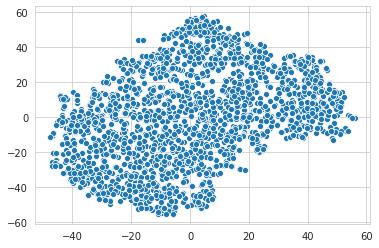

In [18]:
sns.scatterplot(X_tsne[:,0], X_tsne[:,1])

In [19]:
tsne = TSNE(n_components=2,learning_rate=300,perplexity = 30,early_exaggeration = 12,init = 'random',  random_state=2019)
X_tsne = tsne.fit_transform(sentiments)

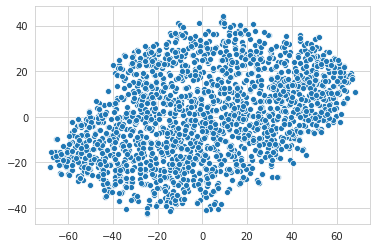

In [20]:
sns.scatterplot(X_tsne[:,0], X_tsne[:,1])

In [21]:
import scipy.spatial.distance
distances = []
for i, vec in enumerate(vectors):
    for vec2 in vectors[i+1:]:
        distances.append(scipy.spatial.distance.cosine(vec, vec2))


Text(0.5, 0, 'Cosine distance')

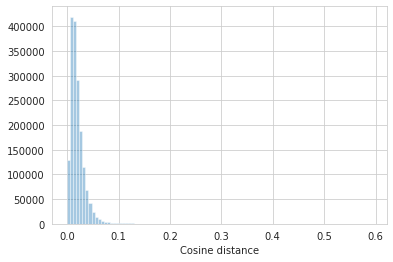

In [22]:
distances = np.array(distances)
tdistances = distances[distances<1]
sns.distplot(tdistances, bins=100, kde=False)
plt.xlabel("Cosine distance")

/home/msimet/anaconda3/envs/goodreads/lib/python3.7/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/home/msimet/anaconda3/envs/goodreads/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/msimet/anaconda3/envs/goodreads/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 0, 'Cosine distance')

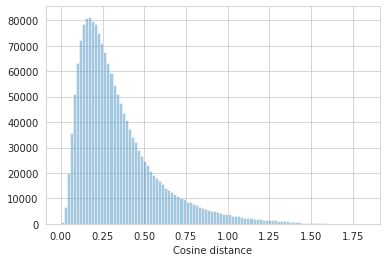

In [23]:
sentiment_distances = []
for i, vec in enumerate(sentiments):
    for vec2 in sentiments[i+1:]:
        sentiment_distances.append(scipy.spatial.distance.cosine(vec, vec2))

tdistances = np.array(sentiment_distances)
sns.distplot(tdistances, bins=100, kde=False)
plt.xlabel("Cosine distance")

In [25]:
sentiments[:,0].shape

(1864,)

In [21]:
if False:
    #reviews = [remove_proper_nouns(review) for review in review_data['reviews']]
    #reviews = [[[lemmatizer.lemmatize(t) for t in nltk.word_tokenize(sentence)]
    #            for sentence in review if sentence]
    #           for review in reviews]
    #reviews = [[[r for r in sentence if r not in stopwords and len(r)>3] for sentence in review] for review in reviews]
    reviews = sav_reviews

    def combo_lists(l):
        ret = []
        for ll in l:
            ret.extend(ll)
        return ret

    bow_reviews = [combo_lists(r) for r in reviews]

    from collections import Counter
    counts = Counter(combo_lists(bow_reviews))

    strength_of_negative = 0.3

    # this gives us -strength_of_negative not nom, 0.5*(1-strength_of_negative) nom, 1 win
    winner_frac = (1+strength_of_negative)*review_data['winner_frac']-strength_of_negative
    winner_frac = winner_frac.values

    sorted_wordlist = [w for w in counts]
    sorted_wordlist.sort(key=lambda x: counts[x], reverse=True)
    sorted_wordlist = sorted_wordlist[:250]

    correlations = []
    for word in sorted_wordlist:
        word_counts = [1.0*review.count(word)/(len(review)+1.E-8) for review in bow_reviews]
        # item [1] of the tuple is the p-value; low is better (reject hypothesis uncorrelated)
        correlations.append(scipy.stats.spearmanr(word_counts, winner_frac)[1])

    word_correlations = [(c, w) for c, w in zip(correlations, sorted_wordlist)]

In [22]:
if False:
    word_correlations.sort()
    for c, w in word_correlations[:20]:
        print(c, w)

2.935177479766249e-07 narrative
6.480954715155875e-06 human
7.685016077787229e-06 written
8.17691546348056e-06 future
1.111436771033997e-05 detail
2.1716962381885477e-05 science
2.3127496375459508e-05 space
3.6186287943986575e-05 often
6.821455747018931e-05 must
9.738318608684844e-05 society
0.0001372304339195379 protagonist
0.00014437167852212265 perhaps
0.00016885577668459436 fiction
0.0001793347517252326 evil
0.00019116583342877438 experience
0.00028363092232390507 work
0.0003355490392016078 event
0.00037352221637900195 sci-fi
0.0004009637605493751 remember
0.00040233776149548766 people


In [34]:
query = ("SELECT * FROM works_withgenre")
all_data = pd.read_sql_query(query, con)

for i in range(10):
    all_data['review_embed{}'.format(i)] = sentiments[:,i]

#for i in range(10):
#    all_data['word_embed{}'.format(i)] = [1.0*review.count(sorted_wordlist[i][1])/(len(review)+1E-8) for review in bow_reviews]

In [35]:
all_data = all_data.drop(columns=["reviews"])

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(username, password, host, port, db_name))
all_data.to_sql('works_withgenrelang', engine, if_exists='replace') 

In [36]:
all_data['review_embed1']

0       0.182297
1       0.026515
2       0.137771
3       0.172675
4       0.101132
          ...   
1859    0.178044
1860    0.000000
1861    0.168405
1862   -0.005089
1863    0.125871
Name: review_embed1, Length: 1864, dtype: float64